# 03 – Modelo predictivo: **Readmisión en 30 días**
*Prueba técnica – Ingeniería de Datos*

Objetivo: predecir la variable binaria `readmission_within_30_days`.


In [1]:

import sys, pathlib
PROJECT_ROOT = pathlib.Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
import joblib
from SRC.config import PG_URI

engine = create_engine(PG_URI, pool_pre_ping=True)


PROJECT_ROOT: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf
RAW_CSV_PATH: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf\DATA\dataset_salud_500k.csv
CLEAN_DATA_DIR: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf\DATA
CLEAN_PARQUET_PATH: C:\Users\GRANDALF TELLERIAS\OneDrive - STI DATA AND BUSINESS INTELLIGENCE\Desktop\PruebaTecnicaGrandalf\DATA\clean_dataset.parquet
None


## 1. Cargar datos

In [3]:

query = """
SELECT age, gender, specialty, visit_type, visit_duration_minutes,
       outcome, cost_usd, readmission_within_30_days
FROM atenciones_medicas
WHERE readmission_within_30_days IS NOT NULL
"""
df = pd.read_sql(query, engine)
print(df.shape)
df.head()


(432010, 8)


,age,gender,specialty,visit_type,visit_duration_minutes,outcome,cost_usd,readmission_within_30_days
0,6,F,Neurología,Consulta,586,Fallecimiento,3353.23,0
1,17,M,Cirugía,Consulta,179,Fallecimiento,4532.81,1
2,52,F,Ortopedia,Consulta,99,Reingreso,3527.03,0
3,62,M,Pediatría,Emergencia,520,Referencia,1613.31,1
4,49,M,Cirugía,Emergencia,355,Referencia,815.54,0


## 2. Preparar conjunto de entrenamiento

In [4]:

y = df['readmission_within_30_days']
X = df.drop(columns=['readmission_within_30_days'])

num_cols = ['age', 'visit_duration_minutes', 'cost_usd']
cat_cols = ['gender', 'specialty', 'visit_type', 'outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, y_train.mean())


(345608, 7) 0.15046526700770815


## 3. Pipeline y entrenamiento

Muestreo y dataset de trabajo

In [6]:
# Seleccionamos 120 000 registros (~24 % del dataset original)
df_sample = df.sample(n=120_000, random_state=42)

# Definimos variable objetivo (y) y conjunto de features (X)
y = df_sample['readmission_within_30_days']
X = df_sample.drop(columns=['readmission_within_30_days'])

num_cols = ['age', 'visit_duration_minutes', 'cost_usd']
cat_cols = ['gender', 'specialty', 'visit_type', 'outcome']
print(X.shape, y.mean())   # tamaño del dataset y proporción positiva

(120000, 7) 0.149875


Partición train / test

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print(X_train.shape, X_test.shape)

(96000, 7) (24000, 7)


Pipeline de preprocesamiento

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_tf   = Pipeline([('scale', StandardScaler())])
categoric_tf = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_cols),
        ('cat', categoric_tf, cat_cols)
    ]
)

Entrenamiento del modelo

In [12]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    max_iter=300,
    class_weight='balanced',
    n_jobs=-5,
    solver='saga'           # compatible con n_jobs y grandes volúmenes
)

pipe = Pipeline([
    ('prep', preprocess),
    ('clf',  logreg)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'visit_duration_minutes',
                                                   'cost_usd']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'specialty',
                                                   'visit_type',
                                                   'outcome'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    n_jobs=-5, solver='saga'))])

## 4. Evaluación

Accuracy: 0.508
Precision: 0.153
Recall: 0.505
ROC-AUC: 0.504


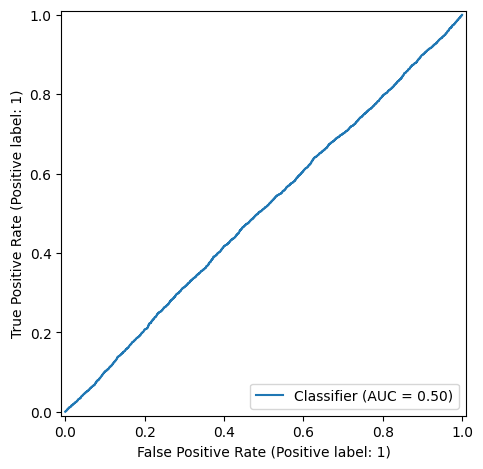

In [13]:

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print(f'Accuracy: {acc:.3f}\nPrecision: {prec:.3f}\nRecall: {rec:.3f}\nROC-AUC: {auc:.3f}')

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.tight_layout()
plt.show()


## 5. Guardar modelo

In [14]:

from pathlib import Path
Path('models').mkdir(exist_ok=True)
joblib.dump(pipe, 'models/readmission_rf.joblib')
print('Modelo guardado en models/readmission_rf.joblib')


Modelo guardado en models/readmission_rf.joblib
